In [1]:
import os
import json
import time
from datetime import datetime, timedelta
import shutil

import requests

In [2]:
huc12 = "070200030503"
start_datetime = datetime(2016, 1, 1, 0)
end_datetime = datetime(2016, 1, 2, 0)

In [3]:
workspace = os.getcwd()

## Subset DOMAIN Files with CUAHSI Subsetter REST APIs

In [4]:
# Create a "Simulation" directory

simulation_dir = os.path.join(workspace, 'Simulation')
if os.path.exists(simulation_dir):
    shutil.rmtree(simulation_dir)
os.makedirs(simulation_dir)

#List of files
os.listdir(simulation_dir)

[]

In [5]:
# https://subset.cuahsi.org/wbd/gethucbbox/lcc?hucID=130202030605
# {“hucID”: [“130202030605"], “hucLevel”: [12], “bbox”: [-873529.4807000011, -531770.8907999992, -842744.9576000011, -521793.4159999992]}
#                                                             west,                 south,              east,           north

gethucbbox_url = "https://subset.cuahsi.org/wbd/gethucbbox/lcc?hucID={}".format(huc12)
res = requests.get(gethucbbox_url)
assert res.status_code == 200
gethubbox_res_json = res.json()
west, south, east, north = gethubbox_res_json["bbox"]
print(gethubbox_res_json)


{'hucID': ['070200030503'], 'hucLevel': [12], 'bbox': [64184.53029999882, 527068.1501999982, 73364.89669999882, 536109.8622999982]}


In [6]:
# submit a job via bounding box
submit_url = f'https://subset.cuahsi.org/nwm/v2_0/subset?llat={south}&llon={west}&ulat={north}&ulon={east}&hucs=[]'
res = requests.get(submit_url)
assert res.status_code == 200

# grab the job identifier
uid = res.url.split('jobid=')[-1]

# query job status
status_url = f'https://subset.cuahsi.org/jobs/{uid}'

attempt = 0
max_attempts = 100

while attempt < max_attempts:
    print("subsetting domain files" + ".." * (attempt+1))
    res = requests.get(status_url)
    status = json.loads(res.text)['status']
    if status == 'finished':
        print("downloading...")
        break
    attempt += 1
    time.sleep(10)
    
# download the result
dl_url = f'https://subset.cuahsi.org/download-zip/{uid}'

local_filename = f'{uid}.zip'
with requests.get(dl_url, stream=True) as r:
    with open(local_filename, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
        
        
# unzip the domain data and remove the zipped one
!unzip -o "$uid".zip -d DOMAIN
!rm -rf "$uid".zip

subsetting domain files..
subsetting domain files....
subsetting domain files......
subsetting domain files........
subsetting domain files..........
subsetting domain files............
subsetting domain files..............
subsetting domain files................
subsetting domain files..................
subsetting domain files....................
subsetting domain files......................
subsetting domain files........................
subsetting domain files..........................
subsetting domain files............................
subsetting domain files..............................
subsetting domain files................................
subsetting domain files..................................
downloading...
Archive:  b41ff12ea4b81da9c889551fff3075143657e2f9.zip
  inflating: DOMAIN/wrfinput_d0x.nc  
  inflating: DOMAIN/hydro2dtbl.nc    
  inflating: DOMAIN/spatialweights.nc  
  inflating: DOMAIN/GWBUCKPARM.nc    
  inflating: DOMAIN/soil_properties.nc  
  inflating: DOMAIN/R

In [7]:
# Move DOMAIN directory to Simulation directory

# Source path (DOMAIN directory)
domain = os.path.join(workspace, "DOMAIN")
  
# Move the content of source to destination
shutil.move(domain, simulation_dir)

'/home/jovyan/work/community_hydrologic_modeling_wrfhydro/Simulation/DOMAIN'

## Subset FORCINGS with GeoEDF Data Processor on CyberGIS Compute

In [8]:
params_subset_domain = {"hucid_12": huc12, 
                        "start_date": start_datetime.strftime("%m/%d/%Y"), 
                        "end_date": end_datetime.strftime("%m/%d/%Y")}
params_subset_domain

{'hucid_12': '070200030503',
 'start_date': '01/01/2016',
 'end_date': '01/02/2016'}

In [9]:
import cybergis_compute_client
from cybergis_compute_client import CyberGISCompute

cybergis = CyberGISCompute(url="cgjobsup.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")
cybergis.show_ui(defaultJob="Subset_AORC_Forcing_Data_Processor") # input_params=params_subset_domain)

In [10]:
job_subset_domain = cybergis.job
forcing_path_HPC = "{}".format(job_subset_domain.id)
forcing_path_HPC

'1661876891KU8Ji'

## Prepare Model Configurations

In [11]:
# setEnvar.sh ---> SPATIAL_SOIL=1 export HYDRO_D=1

In [12]:
! wget https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/setEnvar.sh
! sed -i '/export HYDRO_D=0/c\export HYDRO_D=1' ./setEnvar.sh
! sed -i '/export SPATIAL_SOIL=0/c\export SPATIAL_SOIL=1' ./setEnvar.sh
! cat ./setEnvar.sh | grep -E 'HYDRO_D|SPATIAL_SOIL'
! mv ./setEnvar.sh {simulation_dir}

--2022-08-30 16:28:42--  https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/setEnvar.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532 [text/plain]
Saving to: ‘setEnvar.sh’

setEnvar.sh         100%[===================>]     532  --.-KB/s    in 0s      

2022-08-30 16:28:43 (24.1 MB/s) - ‘setEnvar.sh’ saved [532/532]

export HYDRO_D=1
export SPATIAL_SOIL=1


In [13]:
# namelist.hrldas --> START_YEAR START_MONTH START_DAY START_HOUR START_MIN RESTART_FILENAME_REQUESTED
start_year = start_datetime.year
start_month = "{:02d}".format(start_datetime.month)
start_day = "{:02d}".format(start_datetime.day)
start_hour = "{:02d}".format(start_datetime.hour)
start_minute = "{:02d}".format(start_datetime.minute)
khour = (end_datetime - start_datetime) / timedelta(hours=1)
khour = "{}".format(int(khour))

In [14]:
! rm -rf namelist.hrldas
! wget https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/NoahMP/namelist.hrldas
! sed -i  '/HRLDAS_SETUP_FILE/c\HRLDAS_SETUP_FILE = "./DOMAIN/wrfinput_d0x.nc"' ./namelist.hrldas
! sed -i  '/START_YEAR/c\START_YEAR = '"$start_year" ./namelist.hrldas
! sed -i  '/START_MONTH/c\START_MONTH = '"$start_month" ./namelist.hrldas
! sed -i  '/START_DAY/c\START_DAY = '"$start_day" ./namelist.hrldas
! sed -i  '/START_HOUR/c\START_HOUR = '"$start_hour" ./namelist.hrldas
! sed -i  '/START_MIN/c\START_MIN = '"$start_minute" ./namelist.hrldas
! sed -i  '/KHOUR =/c\KHOUR = '"$khour" ./namelist.hrldas
! sed -i  '/RESTART_FILENAME_REQUESTED/c\!RESTART_FILENAME_REQUESTED = ""' ./namelist.hrldas
! cat ./namelist.hrldas | grep -E 'HRLDAS_SETUP_FILE|START_|KHOUR'
! mv ./namelist.hrldas {simulation_dir}

--2022-08-30 16:28:44--  https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/NoahMP/namelist.hrldas
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2425 (2.4K) [text/plain]
Saving to: ‘namelist.hrldas’

namelist.hrldas     100%[===================>]   2.37K  --.-KB/s    in 0s      

2022-08-30 16:28:44 (42.8 MB/s) - ‘namelist.hrldas’ saved [2425/2425]

HRLDAS_SETUP_FILE = "./DOMAIN/wrfinput_d0x.nc"
START_YEAR = 2016
START_MONTH = 01
START_DAY = 01
START_HOUR = 00
START_MIN = 00
!RESTART_FILENAME_REQUESTED = ""
KHOUR = 24
RESTART_FREQUENCY_HOURS = 24


In [15]:
# hydro.namelist  --> RESTART_FILE
! rm -rf hydro.namelist
! wget https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/HYDRO/hydro.namelist
! sed -i '/GEO_STATIC_FLNM/c\GEO_STATIC_FLNM = "./DOMAIN/geo_em.d0x.nc"' ./hydro.namelist
! sed -i '/RESTART_FILE/c\!RESTART_FILE = ""' ./hydro.namelist
! sed -i '/outlake/c\outlake  = 0' ./hydro.namelist
! sed -i '/output_gw/c\output_gw  = 0' ./hydro.namelist
! sed -i '/GWBASESWCRT/c\GWBASESWCRT  = 0' ./hydro.namelist
! sed -i '/route_lake_f/c\route_lake_f  = ""' ./hydro.namelist
! cat hydro.namelist | grep -E "RESTART|outlake|GWBASESWCRT|route_lake_f"
! mv ./hydro.namelist {simulation_dir}

--2022-08-30 16:28:48--  https://raw.githubusercontent.com/NCAR/wrf_hydro_nwm_public/v5.2.0/trunk/NDHMS/template/HYDRO/hydro.namelist
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11277 (11K) [text/plain]
Saving to: ‘hydro.namelist’

hydro.namelist      100%[===================>]  11.01K  --.-KB/s    in 0s      

2022-08-30 16:28:48 (90.8 MB/s) - ‘hydro.namelist’ saved [11277/11277]

!RESTART_FILE = ""
GW_RESTART = 1
outlake  = 0
route_lake_f  = ""
GWBASESWCRT  = 0


## Run WRFHydro Model on HPC with CyberGIS Compute

In [16]:
params_wrfhydro = {"Model_Version": "v5.2.0",
                   "Forcing_Path": forcing_path_HPC}
params_wrfhydro

{'Model_Version': 'v5.2.0', 'Forcing_Path': '1661876891KU8Ji'}

In [17]:
cybergis.create_job_by_ui(defaultJob="wrfhydro-5.x", defaultDataFolder=simulation_dir)  #,input_params=params_wrfhydro)

## Postprocesing

In [18]:
!echo {cybergis.recentDownloadPath}/

/home/jovyan/work/globus_download_16618769455xpCQ/


In [19]:
!ls -LR {cybergis.recentDownloadPath}/

/home/jovyan/work/globus_download_16618769455xpCQ/:
Outputs  Outputs_Merged  Simulation  slurm_log

/home/jovyan/work/globus_download_16618769455xpCQ/Outputs:
CHRTOUT  diag_hydro  HYDRO_RST	LDASOUT  RESTART  RTOUT

/home/jovyan/work/globus_download_16618769455xpCQ/Outputs/CHRTOUT:
201601010000.CHRTOUT_DOMAIN1  201601011300.CHRTOUT_DOMAIN1
201601010100.CHRTOUT_DOMAIN1  201601011400.CHRTOUT_DOMAIN1
201601010200.CHRTOUT_DOMAIN1  201601011500.CHRTOUT_DOMAIN1
201601010300.CHRTOUT_DOMAIN1  201601011600.CHRTOUT_DOMAIN1
201601010400.CHRTOUT_DOMAIN1  201601011700.CHRTOUT_DOMAIN1
201601010500.CHRTOUT_DOMAIN1  201601011800.CHRTOUT_DOMAIN1
201601010600.CHRTOUT_DOMAIN1  201601011900.CHRTOUT_DOMAIN1
201601010700.CHRTOUT_DOMAIN1  201601012000.CHRTOUT_DOMAIN1
201601010800.CHRTOUT_DOMAIN1  201601012100.CHRTOUT_DOMAIN1
201601010900.CHRTOUT_DOMAIN1  201601012200.CHRTOUT_DOMAIN1
201601011000.CHRTOUT_DOMAIN1  201601012300.CHRTOUT_DOMAIN1
201601011100.CHRTOUT_DOMAIN1  201601020000.CHRTOUT_DOMAIN1
2016010112

In [20]:
import xarray as xr
chrtout = xr.open_mfdataset('{}/Outputs/CHRTOUT/*CHRTOUT*'.format(cybergis.recentDownloadPath),
                            combine='by_coords')
chrtout

<xarray.Dataset>
Dimensions:         (time: 25, reference_time: 1, feature_id: 172)
Coordinates:
  * time            (time) datetime64[ns] 2016-01-01 ... 2016-01-02
  * reference_time  (reference_time) datetime64[ns] 2016-01-01
  * feature_id      (feature_id) int32 1 2 3 4 5 6 7 ... 167 168 169 170 171 172
    latitude        (feature_id) float32 dask.array<chunksize=(172,), meta=np.ndarray>
    longitude       (feature_id) float32 dask.array<chunksize=(172,), meta=np.ndarray>
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    order           (time, feature_id) int32 dask.array<chunksize=(1, 172), meta=np.ndarray>
    elevation       (time, feature_id) float32 dask.array<chunksize=(1, 172), meta=np.ndarray>
    streamflow      (time, feature_id) float32 dask.array<chunksize=(1, 172), meta=np.ndarray>
    q_lateral       (time, feature_id) float32 dask.array<chunksize=(1, 172), meta=np.ndarray>
    velocity        (time, feature_id) float32 dask.array<chunksize=(1, 172), meta=np.ndarray>
    Head            (time, feature_id) float32 dask.array<chunksize=(1, 172), meta=np.ndarray>
Attributes: (12/18)
    TITLE:                      OUTPUT FROM WRF-Hydro v5.2.0
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2016-01-01_00:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2016-01-01_00:00:00
    ...                         ...
    model_configuration:        default
    dev_OVRTSWCRT:              1
    dev_NOAH_TIMESTEP:          3600
    dev_channel_only:           0
    dev_channelBucket_only:     0
    dev:                        dev_ prefix indicates development/internal me...

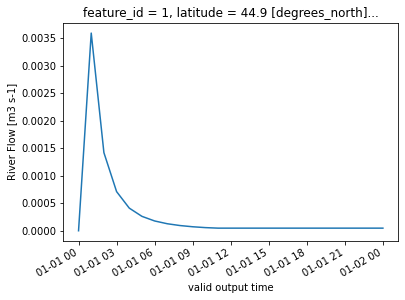

In [21]:
chrtout.sel(feature_id = 1).streamflow.plot()